In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# Plotting style
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

C:\Users\Aniket Bhardwaj\AppData\Local\Temp\ipykernel_21320\3795059040.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [4]:
# Load cleaned data
df = pd.read_csv("../data/AAPL.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df = df.sort_index()

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,40.479832,40.489233,39.774854,39.986349,102223600
2018-01-03,40.472786,41.017971,40.409341,40.543284,118071600
2018-01-04,40.660786,40.764183,40.437543,40.545638,89738400
2018-01-05,41.123722,41.210668,40.665487,40.757134,94640000
2018-01-08,40.970978,41.267067,40.872278,40.970978,82271200


In [5]:
# Define window sizes
sma_window = 50
ema_window = 20

# Add moving averages
df["SMA"] = df["Close"].rolling(window=sma_window).mean()
df["EMA"] = df["Close"].ewm(span=ema_window, adjust=False).mean()


In [6]:
# Generate crossover signals
df["Signal"] = 0
df.loc[df["EMA"] > df["SMA"], "Signal"] = 1
df.loc[df["EMA"] < df["SMA"], "Signal"] = 0

# Entry/exit positions
df["Position"] = df["Signal"].diff()


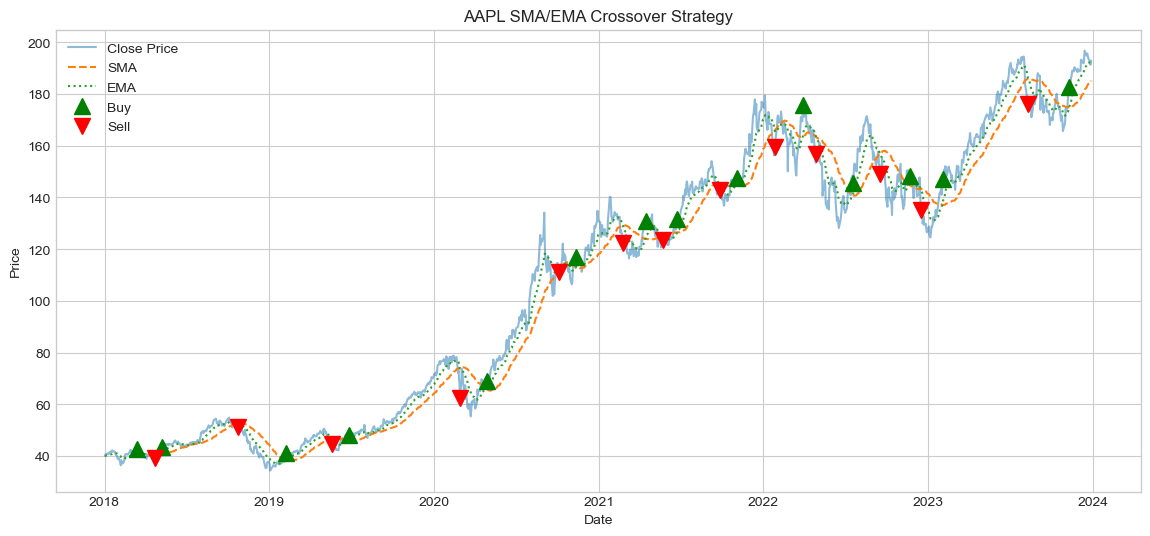

In [7]:
plt.plot(df["Close"], label="Close Price", alpha=0.5)
plt.plot(df["SMA"], label="SMA", linestyle="--")
plt.plot(df["EMA"], label="EMA", linestyle=":")

# Buy signals (Position == 1)
plt.plot(df[df["Position"] == 1].index, 
         df["Close"][df["Position"] == 1], 
         "^", markersize=12, color="g", label="Buy")

# Sell signals (Position == -1)
plt.plot(df[df["Position"] == -1].index, 
         df["Close"][df["Position"] == -1], 
         "v", markersize=12, color="r", label="Sell")

plt.title("AAPL SMA/EMA Crossover Strategy")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Calculate daily return of the stock
df["Market_Return"] = df["Close"].pct_change()

In [9]:
# Forward-fill the signal to maintain position after entry
df["Strategy_Position"] = df["Signal"].shift(1)  # trade on previous signal

# Strategy return = Market return * position
df["Strategy_Return"] = df["Market_Return"] * df["Strategy_Position"]


In [10]:
df["Cumulative_Market_Return"] = (1 + df["Market_Return"]).cumprod()
df["Cumulative_Strategy_Return"] = (1 + df["Strategy_Return"]).cumprod()


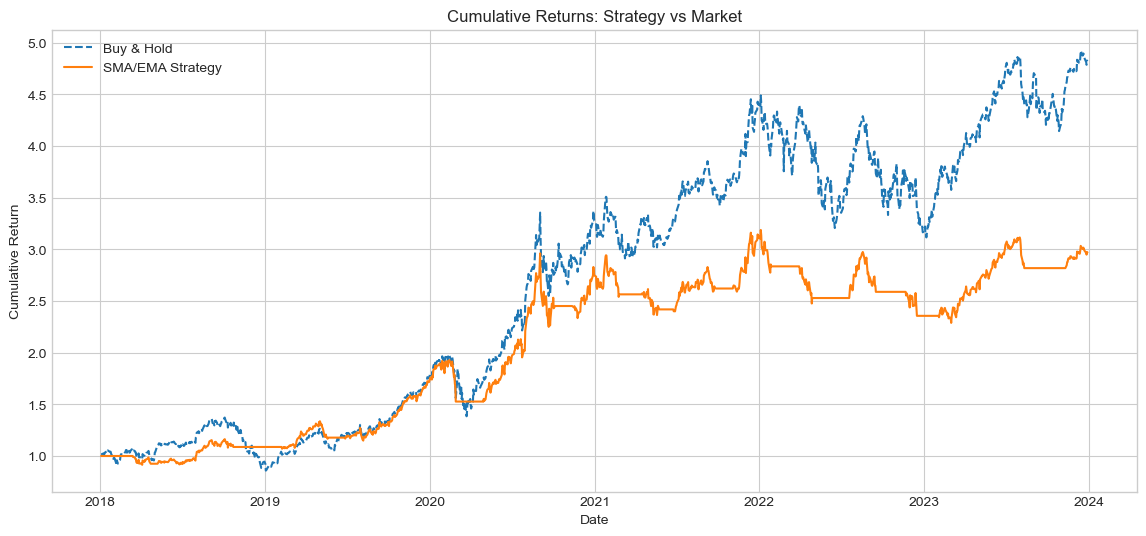

In [11]:
plt.plot(df["Cumulative_Market_Return"], label="Buy & Hold", linestyle="--")
plt.plot(df["Cumulative_Strategy_Return"], label="SMA/EMA Strategy", linestyle="-")
plt.title("Cumulative Returns: Strategy vs Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import sys
import os

# Add the root directory to Python path
sys.path.append(os.path.abspath(".."))

from strategies.sma_ema import sma_ema_strategy

In [17]:
df = pd.read_csv("../data/AAPL.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

df = sma_ema_strategy(df, sma_window=50, ema_window=20)

In [18]:
from backtest_engine.simulate_strategy import simulate_trading

df = simulate_trading(df, initial_cash=100000)
df[["Close", "Cash", "Holdings", "Total Value", "Buy/Sell"]].tail()

,Close,Cash,Holdings,Total Value,Buy/Sell
Date,,,,,
2023-12-22,194.015137,0.0,298944.359820,298944.359820,
2023-12-26,192.454544,0.0,296539.750533,296539.750533,
2023-12-27,191.341204,0.0,294824.283076,294824.283076,
2023-12-28,192.981369,0.0,297351.498218,297351.498218,
2023-12-29,192.742785,0.0,296983.881519,296983.881519,


<Axes: title={'center': 'Portfolio Value Over Time'}, xlabel='Date'>

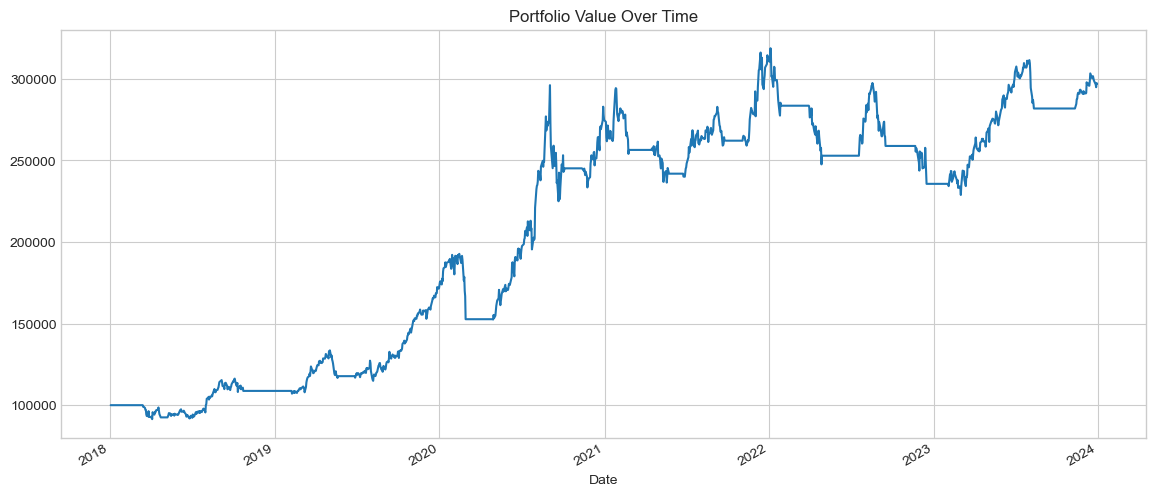

In [19]:
df["Total Value"].plot(title="Portfolio Value Over Time")

In [20]:
import numpy as np

def calculate_performance_metrics(df: pd.DataFrame):
    returns = df["Total Value"].pct_change().dropna()
    sharpe = (returns.mean() / returns.std()) * np.sqrt(252)
    max_drawdown = (df["Total Value"] / df["Total Value"].cummax() - 1).min()
    total_trades = df["Buy/Sell"].isin(["BUY", "SELL"]).sum()

    print(f"📊 Sharpe Ratio: {sharpe:.2f}")
    print(f"📉 Max Drawdown: {max_drawdown:.2%}")
    print(f"🔁 Total Trades: {total_trades}")


In [ ]:
from backtest_engine.simulate_strategy import simulate_trading

df = simulate_trading(df, initial_cash=100000, save_reports=True)
df[["Close", "Buy/Sell", "Total Value"]].tail()


,Close,Buy/Sell,Total Value
Date,,,
2023-12-22,194.015137,,298944.359820
2023-12-26,192.454544,,296539.750533
2023-12-27,191.341204,,294824.283076
2023-12-28,192.981369,,297351.498218
2023-12-29,192.742785,,296983.881519
